In [ ]:
from groq import Groq
from llama_index.core import Settings, ServiceContext, StorageContext, SimpleDirectoryReader, PropertyGraphIndex
from llama_index.llms.groq import Groq as Groq_llamaindex
#from llama_index.llms.ollama import Ollama as Ollama_llamaindex
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.llms.openai import OpenAI
from llama_index.graph_stores.neo4j import Neo4jGraphStore, Neo4jPropertyGraphStore
#from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.core import VectorStoreIndex
from llama_index.core.agent import ReActAgent, FunctionCallingAgentWorker, AgentRunner
from llama_index.core.tools import BaseTool, FunctionTool
from milvus import default_server
from dotenv import load_dotenv
import json
import os
import numpy as np




Settings.llm = llm
Settings.embed_model = HuggingFaceEmbedding(
    model_name="BAAI/bge-small-en-v1.5"
)


ServiceContext.llm = llm

import logging
import sys

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

username = "neo4j"
password = "nzta_neo4j"
url = "bolt://localhost:7687"
database = "neo4j"

property_graph_store = Neo4jPropertyGraphStore(
    username=username,
    password=password,
    url=url,
    database=database,
)
storage_context = StorageContext.from_defaults(property_graph_store=property_graph_store)



index = PropertyGraphIndex.from_existing(
    property_graph_store=property_graph_store,
    llm=llm,
    embed_model=Settings.embed_model,
)


similarity_top_k = 4
path_depth = 4

from llama_index.core.indices.property_graph import VectorContextRetriever

vector_retriever = VectorContextRetriever(
    index.property_graph_store,
    # only needed when the graph store doesn't support vector queries
    # vector_store=index.vector_store,
    embed_model=Settings.embed_model,
    # include source chunk text with retrieved paths
    include_text=True,
    # the number of nodes to fetch
    similarity_top_k=similarity_top_k,
    # the depth of relations to follow after node retrieval
    path_depth=path_depth,
     
)

#retriever = index.as_retriever(sub_retrievers=[vector_retriever])

index_query_engine = index.as_query_engine(sub_retrievers=[vector_retriever])
index_retriever = index.as_retriever(sub_retrievers=[vector_retriever])


/Users/felipenavarro/Documents/Auckland/nzta/nzta_full_path/NZTA-GraphRAG/nzta_full_path_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO:neo4j.notifications:Received notification from DBMS server: {severity: INFORMATION} {code: Neo.ClientNotification.Schema.IndexOrConstraintAlreadyExists} {category: SCHEMA} {title: `CREATE CONSTRAINT IF NOT EXISTS FOR (e:__Node__) REQUIRE (e.id) IS UNIQUE` has no effect.} {description: `CONSTRAINT constraint_ec67c859 FOR (e:__Node__) REQUIRE (e.id) IS UNIQUE` already exists.} {position: None} for query: 'CREATE CONSTRAINT IF NOT EXISTS FOR (n:`__Node__`)\n            REQUIRE n.id IS UNIQUE;'
Received notification from DBMS server: {severity: INFORMATION} {code: Neo.ClientNotification.Schema.IndexOrConstraintAlreadyExists} {category: SCHEMA} {title: `CREATE CONSTRAINT IF NOT EXISTS FOR (e:__Node__) REQUIRE (e.id) IS UNIQUE` has no effect.} {description: `CONSTRAINT constraint_ec67c859 FOR (e:__Node__) REQUIRE (e.id) IS UNIQUE` already exists.} {position: None} for query: 'CREATE CONSTRAINT IF NOT EXISTS FOR (n:`__Node__`)\n            REQUIRE n.id IS UNIQUE;'
INFO:neo4j.notification

In [118]:
from llama_index.core import PromptTemplate, SelectorPromptTemplate

new_summary_tmpl_str = (
    "Context information is below.\n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "Given the context information and not prior knowledge, answer the query.\n"
    "Query: {query_str}\n"
    "Respond as briefly as possible with one single word if possible unless the unser contains multiple words. \n"
    "do not provide an explanation just the answer. If you do not find the answer please just state ' answer not found yet' . Answer: "
)

new_refine_tmpl_str = (
    "The original query is as follows: {query_str}\n"
    "We have provided an existing answer: {existing_answer}\n"
    "We have the opportunity to correct the existing answer (only if needed) with some more context below.\n"
    "------------\n"
    "{context_msg}\n"
    "------------\n"
    "Given the new context, refine the original answer to better answer the query. If the context isn't useful, return the original answer.\n"
    "If you decide to changte the answer it is because you have found significant evidence that it should be correctred. \n"
    "Refined Answer: "
)



new_summary_tmpl = PromptTemplate(new_summary_tmpl_str)
new_refine_tmpl = PromptTemplate(new_refine_tmpl_str)


index_query_engine.update_prompts(
    {"response_synthesizer:text_qa_template": new_summary_tmpl}
)

index_query_engine.update_prompts(
    {"response_synthesizer:refine_template": new_refine_tmpl}
)


In [29]:
# Load questions sp_cot_data/pseudo_dataset_completion.json
import json
with open('sp_cot_data/pseudo_dataset_completion.json') as f:
    data = json.load(f)



In [5]:
types = data.keys()
questions = []
answers = []
for type in types:
    for entry in data[type]:
        questions.append(entry['question'])
        answers.append(entry['answer'])


In [124]:
# Look for quesstions that have the word machine in them
machine_questions = []
machine_answers = []
for i in range(len(questions)):
    if 'machine' in questions[i]:
        machine_questions.append(questions[i])
        machine_answers.append(answers[i])

In [ ]:
import pandas as pd
import nest_asyncio
import time

from pathlib import Path


# Apply asyncio patch for Jupyter notebooks
nest_asyncio.apply()


# Function to get the highest numbered .txt file in a directory
def get_highest_txt_file(directory):
    files = list(Path(directory).glob("*.txt"))
    if not files:
        raise ValueError("No .txt files found.")
    return max(files, key=lambda f: int(f.stem))

# Function to prepend text to the file
def prepend_text(file_path, text):
    content = file_path.read_text()
    file_path.write_text(f"{text}\n{content}")

model_answers = [None] * len(questions)
df_answers = pd.DataFrame(columns=['Question', 'Answer'])

# Loop over all questions where the answer is None or 'none'
for idx, (question, answer) in enumerate(zip(questions, model_answers)):
    if answer is None or answer.strip().lower() == 'none':
        print(f"Processing question {idx}")
        print(question)

        try:
            response = index_query_engine.query(question)

        #     ### Add the response to the txt file with the retrieved nodes
        #     # Parameters
        #     directory_sorted = "/Users/felipenavarro/Desktop/cos_sim_sorted_nodes"
        #     directory_unsorted = "/Users/felipenavarro/Desktop/unsorted_nodes"
        #     # Execution
        #     highest_file_sorted = get_highest_txt_file(directory_sorted)
        #     highest_file_unsorted = get_highest_txt_file(directory_unsorted)
        #     prepend_text(highest_file_sorted, question)
        #     prepend_text(highest_file_unsorted, question)
        #    ############################


            model_answers[idx] = response.response
            print(response.response)

            # Create a new row as a DataFrame
            new_row = pd.DataFrame({'Question': [question], 'Answer': [response.response]})

            # Concatenate the new row to the existing DataFrame
            df_answers = pd.concat([df_answers, new_row], ignore_index=True)

            # Save the updated dataframe to 'temp_answers.csv'
            df_answers.to_csv("temp_answers.csv", index=False)
            
        except Exception as e:
            answers[idx] = None
            print(f"Error: {e}")
            
        print("\n#######################\n")
        time.sleep(0)  # Pause for 20 seconds





import os
import shutil

# # Define the source directories
# source_dir_sorted = "/Users/felipenavarro/Desktop/cos_sim_sorted_nodes"
# source_dir_unsorted = "/Users/felipenavarro/Desktop/unsorted_nodes"

# # Create the destination directories
# dest_dir_sorted = f"/Users/felipenavarro/Desktop/full_sorted_k{similarity_top_k}_d{path_depth}"
# dest_dir_unsorted = f"/Users/felipenavarro/Desktop/full_unsorted_k{similarity_top_k}_d{path_depth}"

# # Copy the directories
# if not os.path.exists(dest_dir_sorted):
#     shutil.copytree(source_dir_sorted, dest_dir_sorted)

# if not os.path.exists(dest_dir_unsorted):
#     shutil.copytree(source_dir_unsorted, dest_dir_unsorted)



# save the results of quesiton answer to a file with the k and d on its name 
df_answers.to_csv(f"questions_and_answers/unsorted_k{similarity_top_k}_d{path_depth}.csv", index=False)

In [ ]:
import pandas as pd
import nltk
import evaluate
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import torch
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm  # For progress bars
import os  # To handle directory operations
from nltk.translate.bleu_score import SmoothingFunction

# Ensure that NLTK has the necessary package for BLEU
nltk.download('punkt')

# Load the BGE model and tokenizer
MODEL_NAME = "BAAI/bge-small-en-v1.5"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bge_model = AutoModel.from_pretrained(MODEL_NAME)
bge_model.eval()  # Set model to evaluation mode

# Function to generate embeddings using BGE with caching
class EmbeddingCache:
    def __init__(self, tokenizer, model, device='cpu', batch_size=32):
        self.tokenizer = tokenizer
        self.model = model
        self.device = device
        self.batch_size = batch_size
        self.cache = {}
        
    def get_embeddings(self, texts):
        """
        Generates embeddings for a list of texts with caching to avoid redundant computations.
        
        Args:
            texts (List[str]): List of text strings to embed.
        
        Returns:
            List[np.ndarray]: List of embedding vectors.
        """
        texts_to_embed = [text for text in texts if text not in self.cache]
        if texts_to_embed:
            for i in tqdm(range(0, len(texts_to_embed), self.batch_size), desc="Embedding texts"):
                batch = texts_to_embed[i:i+self.batch_size]
                inputs = self.tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to(self.device)
                with torch.no_grad():
                    embeddings = self.model(**inputs).last_hidden_state.mean(dim=1).cpu().numpy()
                for text, emb in zip(batch, embeddings):
                    self.cache[text] = emb
        return [self.cache[text] for text in texts]

embedding_cache = EmbeddingCache(tokenizer, bge_model, device='cpu', batch_size=32)

# Function to calculate cosine similarity
def calculate_cosine_similarity(embeddings1, embeddings2):
    return cosine_similarity(embeddings1, embeddings2).diagonal()

# BLEU score calculation
# def calculate_bleu(reference, hypothesis):
#     reference_tokens = [nltk.word_tokenize(reference)]  # Reference must be a list of lists for BLEU
#     hypothesis_tokens = nltk.word_tokenize(hypothesis)
#     return sentence_bleu(reference_tokens, hypothesis_tokens)

# BLEU score calculation with smoothing
def calculate_bleu(reference, hypothesis):
    reference_tokens = [nltk.word_tokenize(reference)]  # Reference must be a list of lists for BLEU
    hypothesis_tokens = nltk.word_tokenize(hypothesis)
    
    # Apply smoothing method for short sentences
    smoothing_function = SmoothingFunction().method4  # You can try different smoothing methods (method1 to method7)
    
    return sentence_bleu(reference_tokens, hypothesis_tokens, smoothing_function=smoothing_function)


# ROUGE score calculation
rouge = evaluate.load("rouge")

def calculate_rouge_per_row(reference, prediction):
    """
    Compute ROUGE scores for a single (reference, prediction) pair.
    
    Args:
        reference (str): The reference text.
        prediction (str): The prediction text.
        
    Returns:
        dict: Dictionary containing ROUGE-1, ROUGE-2, and ROUGE-L scores.
    """
    try:
        scores = rouge.compute(predictions=[prediction], references=[reference])
        return {
            'ROUGE-1': scores['rouge1'],
            'ROUGE-2': scores['rouge2'],
            'ROUGE-L': scores['rougeL']
        }
    except Exception as e:
        print(f"Error computing ROUGE for reference: {reference} and prediction: {prediction}\n{e}")
        return {'ROUGE-1': float('nan'), 'ROUGE-2': float('nan'), 'ROUGE-L': float('nan')}


# **Ensure that all lists have the same length**
assert len(questions) == len(answers) == len(model_answers), "Length of 'questions', 'answers', and 'model_answers' must be equal."

# Create a DataFrame
data = pd.DataFrame({
    'Question': questions,
    'Answer': answers,
    'Model Answer': model_answers
})

# Ensure all entries in 'Question', 'Answer', and 'Model Answer' are strings
data['Question'] = data['Question'].astype(str)
data['Answer'] = data['Answer'].astype(str)
data['Model Answer'] = data['Model Answer'].astype(str)

# Collect all unique references and hypotheses for embedding
unique_texts = pd.concat([data['Answer'], data['Model Answer']]).unique()
embedding_cache.get_embeddings(unique_texts)

# Calculate embeddings
data['Reference Embedding'] = embedding_cache.get_embeddings(data['Answer'])
data['Hypothesis Embedding'] = embedding_cache.get_embeddings(data['Model Answer'])

# Calculate cosine similarities
data['Cosine Similarity'] = calculate_cosine_similarity(
    list(data['Reference Embedding']),
    list(data['Hypothesis Embedding'])
)

# Calculate BLEU scores with a progress bar
bleu_scores = []
for idx, row in tqdm(data.iterrows(), total=data.shape[0], desc="Calculating BLEU"):
    reference = row['Answer']
    hypothesis = row['Model Answer']
    bleu = calculate_bleu(reference, hypothesis)
    bleu_scores.append(bleu)
data['BLEU'] = bleu_scores

# Calculate ROUGE scores per row with a progress bar
rouge_scores_1 = []
rouge_scores_2 = []
rouge_scores_L = []
for idx, row in tqdm(data.iterrows(), total=data.shape[0], desc="Calculating ROUGE"):
    reference = row['Answer']
    prediction = row['Model Answer']
    rouge_result = calculate_rouge_per_row(reference, prediction)
    rouge_scores_1.append(rouge_result['ROUGE-1'])
    rouge_scores_2.append(rouge_result['ROUGE-2'])
    rouge_scores_L.append(rouge_result['ROUGE-L'])
data['ROUGE-1'] = rouge_scores_1
data['ROUGE-2'] = rouge_scores_2
data['ROUGE-L'] = rouge_scores_L

# Add metadata (you can modify these as needed)
data['Sort Status'] = 'unsorted'  # or 'sorted' if appropriate
data['k'] = 0  # default value
data['d'] = 0  # default value

# **Include 'Question', 'Answer', and 'Model Answer' in the summary_results DataFrame**
summary_results = data[['Question', 'Answer', 'Model Answer', 'Sort Status', 'k', 'd', 'BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'Cosine Similarity']]

# Save the summary DataFrame to a CSV file
summary_csv_path = 'summary_evaluations.csv'
summary_results.to_csv(summary_csv_path, index=False)
print(f"Summary evaluations saved to {summary_csv_path}")

# **Ensure the 'summaries/' directory exists**
os.makedirs('summaries', exist_ok=True)



sorted_csv_path = f"summaries/unsorted_results_{similarity_top_k}_{path_depth}.csv"
summary_results.to_csv(sorted_csv_path, index=False)
print(f"Summary evaluations saved to {sorted_csv_path}")


In [21]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binomtest, shapiro, ttest_rel

# Directory paths
SUMMARY_DIR = 'summaries/'
PLOTS_DIR = 'plots/'

# Ensure plots directory exists
os.makedirs(PLOTS_DIR, exist_ok=True)

# Metrics to analyze
METRICS = ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'Cosine Similarity']

def load_files(summary_dir, k, d):
    """Load sorted and unsorted CSV files for given k and d."""
    sorted_path = os.path.join(summary_dir, f"sorted_results_{k}_{d}.csv")
    unsorted_path = os.path.join(summary_dir, f"unsorted_results_{k}_{d}.csv")
    if os.path.exists(sorted_path) and os.path.exists(unsorted_path):
        return pd.read_csv(sorted_path), pd.read_csv(unsorted_path)
    return None, None

def process_files(summary_dir):
    """Process all sorted and unsorted file pairs and perform statistical tests."""
    results_list = []
    for filename in os.listdir(summary_dir):
        if filename.startswith("sorted_results_") and filename.endswith(".csv"):
            parts = filename.replace("sorted_results_", "").replace(".csv", "").split("_")
            if len(parts) == 2:
                k, d = parts
                k = int(k)
                d = int(d)
                sorted_df, unsorted_df = load_files(summary_dir, k, d)
                if sorted_df is not None and unsorted_df is not None:
                    for metric in METRICS:
                        mean_sorted = sorted_df[metric].mean()
                        mean_unsorted = unsorted_df[metric].mean()
                        try:
                            # Calculate the differences
                            differences = sorted_df[metric] - unsorted_df[metric]
                            non_zero_differences = differences[differences != 0]
                            n = len(non_zero_differences)

                            if n == 0:
                                print(f"Tests not performed for {metric} (k={k}, d={d}) due to all differences being zero.")
                                stat, p_value, normality_p, test_type = None, None, None, "N/A"
                                n_positive = n_negative = 0
                            else:
                                # Count positive and negative differences
                                n_positive = sum(non_zero_differences > 0)
                                n_negative = sum(non_zero_differences < 0)

                                # Perform Shapiro-Wilk test for normality
                                normality_stat, normality_p = shapiro(non_zero_differences)

                                if normality_p > 0.05:
                                    # If normal, use paired t-test
                                    t_stat, p_value = ttest_rel(sorted_df[metric], unsorted_df[metric])
                                    stat = t_stat
                                    test_type = "t-test"
                                else:
                                    # If not normal, use Binomial Test (Sign Test)
                                    binom_result = binomtest(n_positive, n, 0.5, alternative='two-sided')
                                    stat = n_positive
                                    p_value = binom_result.pvalue
                                    test_type = "Sign Test"

                        except Exception as e:
                            stat, p_value, normality_p, test_type = None, None, None, "Error"
                            n_positive = n_negative = 0

                        results_list.append({
                            'k': k,
                            'd': d,
                            'metric': metric,
                            'mean_sorted': mean_sorted,
                            'mean_unsorted': mean_unsorted,
                            'n_positive': n_positive,
                            'n_negative': n_negative,
                            'normality_p_value': normality_p,
                            'test_type': test_type,
                            'test_statistic': stat,
                            'p_value': p_value
                        })
    return pd.DataFrame(results_list)

def plot_histograms_with_custom_bins(results_df, summary_dir):
    """Generate and save histograms with distinct bins for negative, zero, and positive differences."""
    sns.set(style="whitegrid")
    
    for metric in METRICS:
        metric_entries = results_df[results_df['metric'] == metric]
        unique_kd = metric_entries[['k', 'd']].drop_duplicates()
        num_plots = len(unique_kd)
        cols = 3
        rows = (num_plots + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
        axes = axes.flatten()
        
        for idx, (index, row) in enumerate(unique_kd.iterrows()):
            k = row['k']
            d = row['d']
            sorted_df, unsorted_df = load_files(summary_dir, k, d)
            if sorted_df is not None and unsorted_df is not None:
                differences = sorted_df[metric] - unsorted_df[metric]
                
                # Separate the differences into negative, zero, and positive
                neg_diff = differences[differences < 0]
                zero_diff = differences[differences == 0]
                pos_diff = differences[differences > 0]

                # Create histogram bins
                bins = [-1, 0, 1]
                counts = [len(neg_diff), len(zero_diff), len(pos_diff)]
                labels = ['Negative', 'Zero', 'Positive']
                colors = ['lightcoral', 'gray', 'skyblue']
                
                ax = axes[idx]
                ax.bar(labels, counts, color=colors, edgecolor='black')

                # Set titles and labels
                ax.set_title(f'k={k}, d={d}', fontsize=14)
                ax.set_xlabel('Difference Type', fontsize=12)
                ax.set_ylabel('Count', fontsize=12)
                ax.grid(True)
        
        # Hide any unused subplots
        for ax in axes[num_plots:]:
            ax.axis('off')
        
        plt.suptitle(f'Histogram of Differences in {metric}', fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        plot_filename = f"custom_histogram_difference_metric_{metric.replace('-', '_').replace(' ', '_')}.png"
        plot_path = os.path.join(PLOTS_DIR, plot_filename)
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Saved custom histogram: {plot_path}")

def main():
    results_df = process_files(SUMMARY_DIR)
    
    if results_df.empty:
        print("No valid sorted and unsorted file pairs found.")
        return
    
    display_and_save_results(results_df)
    plot_line_comparisons(results_df)
    plot_histograms_with_custom_bins(results_df, SUMMARY_DIR)
    plot_difference_counts(results_df)
    
    print("\nAll plots have been saved in the 'plots/' directory.")

if __name__ == "__main__":
    main()


/var/folders/zm/7jdzrt5j23gbgc__xf01_jwr0000gn/T/ipykernel_60701/1013973761.py:56: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  normality_stat, normality_p = shapiro(non_zero_differences)
/var/folders/zm/7jdzrt5j23gbgc__xf01_jwr0000gn/T/ipykernel_60701/2701364116.py:96: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  display_df = display_df.applymap(format_value)
/var/folders/zm/7jdzrt5j23gbgc__xf01_jwr0000gn/T/ipykernel_60701/2701364116.py:96: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  display_df = display_df.applymap(format_value)
/var/folders/zm/7jdzrt5j23gbgc__xf01_jwr0000gn/T/ipykernel_60701/2701364116.py:96: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  display_df = display_df.applymap(format_value)
/var/folders/zm/7jdzrt5j23gbgc__xf01_jwr0000gn/T/ipykernel_60701/2701


Statistical results have been saved to 'statistical_results_with_normality.csv' in the 'plots/' directory.

=== Results for d = 1 ===
           metric mean_sorted mean_unsorted normality_p_value test_type test_statistic p_value
             BLEU      0.1861        0.1861               N/A Sign Test         0.0000  1.0000
Cosine Similarity      0.6802        0.6814            0.9968    t-test        -0.4190  0.6760
          ROUGE-1      0.2764        0.2807               N/A Sign Test         0.0000  1.0000
          ROUGE-2      0.0616        0.0702               N/A Sign Test         0.0000  1.0000
          ROUGE-L      0.2764        0.2807               N/A Sign Test         0.0000  1.0000

=== Results for d = 2 ===
           metric mean_sorted mean_unsorted normality_p_value test_type test_statistic p_value
             BLEU      0.2667        0.2858            0.0007 Sign Test        15.0000  0.7011
Cosine Similarity      0.7279        0.7201            0.0285 Sign Test       

In [26]:
results_df = pd.read_csv('plots/statistical_results_with_normality.csv')
results_df[['d', 'metric', 'p_value']]

#save the shortened results to a csv file
results_df[['d', 'metric', 'p_value']].to_csv('spcot_answer_level_statistical_results.csv', index=False)


In [15]:
# load and view statistical results
import pandas as pd
statistical_results = pd.read_csv('plots/statistical_results.csv')
statistical_results

,k,d,metric,mean_sorted,mean_unsorted,wilcoxon_statistic,p_value
0,4,1,BLEU,0.186071,0.186083,0.0,0.317311
1,4,1,Cosine Similarity,0.680223,0.681357,9.0,0.753152
2,4,1,ROUGE-1,0.276437,0.280747,0.0,0.317311
3,4,1,ROUGE-2,0.061576,0.070197,0.0,0.317311
4,4,1,ROUGE-L,0.276437,0.280747,0.0,0.317311
5,4,2,BLEU,0.266700,0.285751,176.0,0.749808
6,4,2,Cosine Similarity,0.727899,0.720070,795.0,0.496932
7,4,2,ROUGE-1,0.364847,0.360249,183.0,0.881827
8,4,2,ROUGE-2,0.075226,0.070608,6.0,0.680280
9,4,2,ROUGE-L,0.364847,0.360249,183.0,0.881827


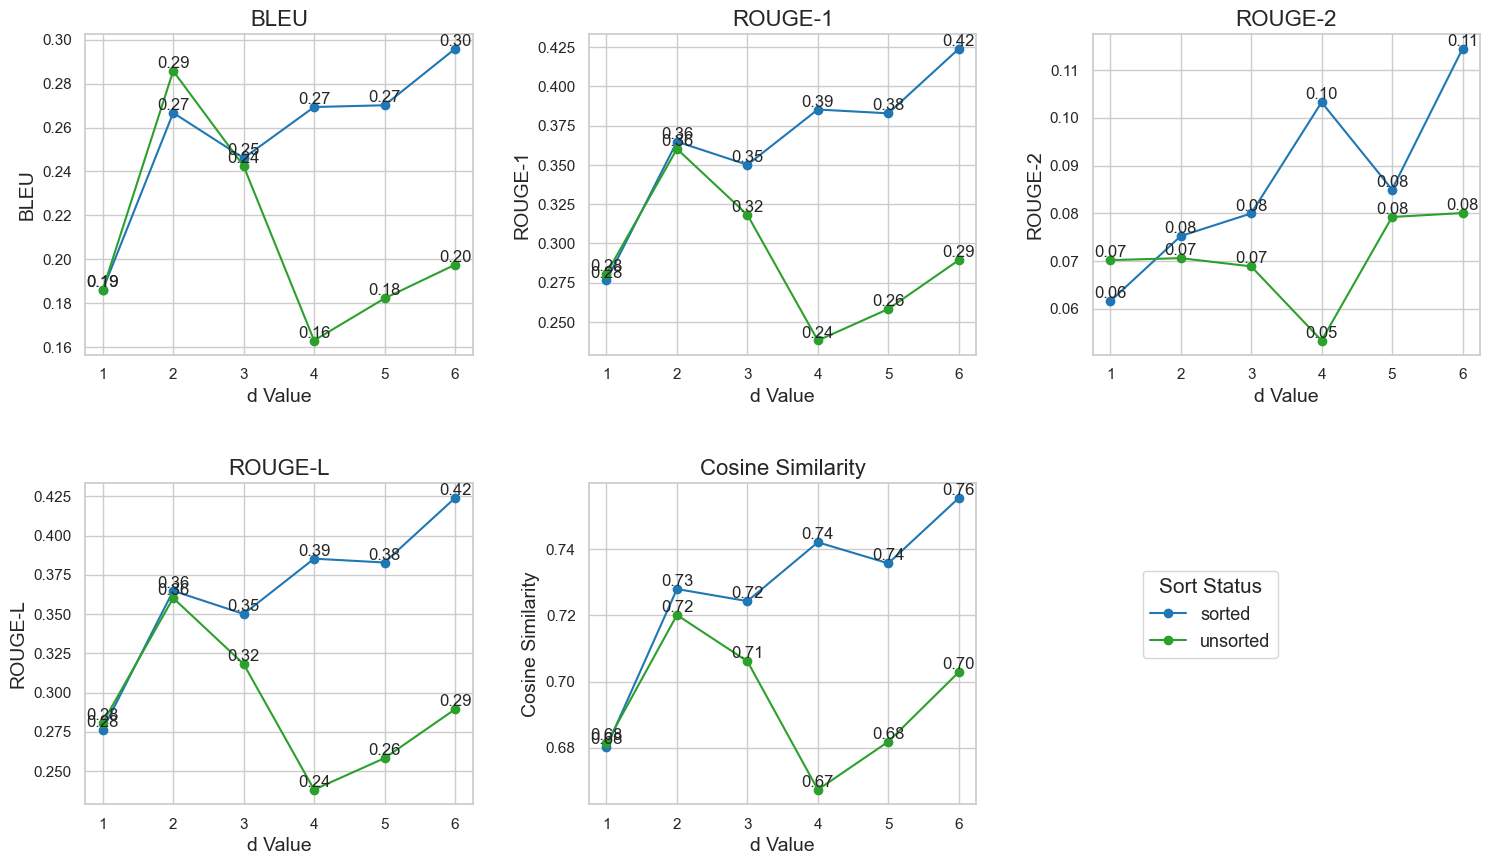

In [11]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon

# Directory paths
SUMMARY_DIR = 'summaries/'

# Metrics to analyze
METRICS = ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'Cosine Similarity']

def load_files(summary_dir, k, d):
    """Load sorted and unsorted CSV files for given k and d."""
    sorted_path = os.path.join(summary_dir, f"sorted_results_{k}_{d}.csv")
    unsorted_path = os.path.join(summary_dir, f"unsorted_results_{k}_{d}.csv")
    if os.path.exists(sorted_path) and os.path.exists(unsorted_path):
        return pd.read_csv(sorted_path), pd.read_csv(unsorted_path)
    return None, None

def process_files(summary_dir):
    """Process all sorted and unsorted file pairs and perform statistical tests."""
    results_list = []
    for filename in os.listdir(summary_dir):
        if filename.startswith("sorted_results_") and filename.endswith(".csv"):
            parts = filename.replace("sorted_results_", "").replace(".csv", "").split("_")
            if len(parts) == 2:
                k, d = parts
                k = int(k)
                d = int(d)
                sorted_df, unsorted_df = load_files(summary_dir, k, d)
                if sorted_df is not None and unsorted_df is not None:
                    for metric in METRICS:
                        mean_sorted = sorted_df[metric].mean()
                        mean_unsorted = unsorted_df[metric].mean()
                        results_list.append({
                            'k': k,
                            'd': d,
                            'metric': metric,
                            'mean_sorted': mean_sorted,
                            'mean_unsorted': mean_unsorted
                        })
    return pd.DataFrame(results_list)

def plot_line_comparisons(results_df):
    """Display line plots in a grid layout comparing sorted and unsorted performance."""
    # Set the aesthetic style of the plots
    sns.set(style="whitegrid")
    sorted_color = '#1f77b4'  # Blue
    unsorted_color = '#2ca02c'  # Green

    # Create a figure with a 2x3 grid for organizing the plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()  # Flatten for easy indexing
    fig.subplots_adjust(hspace=0.4, wspace=0.3)

    for i, metric in enumerate(METRICS):
        ax = axes[i]
        metric_df = results_df[results_df['metric'] == metric].sort_values('d')
        
        # Plot sorted and unsorted data
        ax.plot(metric_df['d'], metric_df['mean_sorted'], marker='o', color=sorted_color, label="sorted", linestyle="-")
        ax.plot(metric_df['d'], metric_df['mean_unsorted'], marker='o', color=unsorted_color, label="unsorted", linestyle="-")
        
        # Set title and labels
        ax.set_title(metric, fontsize=16)
        ax.set_xlabel("d Value", fontsize=14)
        ax.set_ylabel(metric, fontsize=14)
        
        # Add labels to each point
        for j, d in enumerate(metric_df['d']):
            ax.text(d, metric_df['mean_sorted'].iloc[j], f"{metric_df['mean_sorted'].iloc[j]:.2f}", ha="center", va="bottom", fontsize=12)
            ax.text(d, metric_df['mean_unsorted'].iloc[j], f"{metric_df['mean_unsorted'].iloc[j]:.2f}", ha="center", va="bottom", fontsize=12)
    
    # Add a single legend in the empty space of the last plot
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, title="Sort Status", loc="center", fontsize=13, title_fontsize=15, bbox_to_anchor=(0.75, 0.3))

    # Remove the last empty subplot if there are fewer metrics than subplots
    if len(METRICS) < len(axes):
        fig.delaxes(axes[-1])

    plt.show()

def main():
    # Process all file pairs
    results_df = process_files(SUMMARY_DIR)
    
    if results_df.empty:
        print("No valid sorted and unsorted file pairs found.")
        return
    
    # Display line plots
    plot_line_comparisons(results_df)

if __name__ == "__main__":
    main()


In [5]:
# load statistical results
statistical_results = pd.read_csv('plots/statistical_results.csv')
#look at statistical results where d = 1
statistical_results[statistical_results['d'] == 1]

,k,d,metric,mean_sorted,mean_unsorted,wilcoxon_statistic,p_value
0,4,1,BLEU,0.186071,0.186083,0.0,0.317311
1,4,1,Cosine Similarity,0.680223,0.681357,9.0,0.753152
2,4,1,ROUGE-1,0.276437,0.280747,0.0,0.317311
3,4,1,ROUGE-2,0.061576,0.070197,0.0,0.317311
4,4,1,ROUGE-L,0.276437,0.280747,0.0,0.317311


In [6]:
# d2
statistical_results[statistical_results['d'] == 2]


,k,d,metric,mean_sorted,mean_unsorted,wilcoxon_statistic,p_value
5,4,2,BLEU,0.266700,0.285751,176.0,0.749808
6,4,2,Cosine Similarity,0.727899,0.720070,795.0,0.496932
7,4,2,ROUGE-1,0.364847,0.360249,183.0,0.881827
8,4,2,ROUGE-2,0.075226,0.070608,6.0,0.680280
9,4,2,ROUGE-L,0.364847,0.360249,183.0,0.881827


In [7]:
# d3
statistical_results[statistical_results['d'] == 3]

,k,d,metric,mean_sorted,mean_unsorted,wilcoxon_statistic,p_value
10,4,3,BLEU,0.246078,0.242423,217.5,0.756186
11,4,3,Cosine Similarity,0.724255,0.706099,1039.0,0.170861
12,4,3,ROUGE-1,0.350083,0.318213,193.5,0.411914
13,4,3,ROUGE-2,0.079967,0.068883,17.5,0.540544
14,4,3,ROUGE-L,0.350083,0.318213,193.5,0.411914


In [8]:
# d4
statistical_results[statistical_results['d'] == 4]

,k,d,metric,mean_sorted,mean_unsorted,wilcoxon_statistic,p_value
15,4,4,BLEU,0.269340,0.163017,97.5,0.000341
16,4,4,Cosine Similarity,0.742002,0.667385,796.0,0.000127
17,4,4,ROUGE-1,0.385319,0.238164,110.0,0.000583
18,4,4,ROUGE-2,0.103243,0.053366,20.5,0.069450
19,4,4,ROUGE-L,0.385319,0.238164,110.0,0.000583


OpenAI verification

In [9]:
# d5
statistical_results[statistical_results['d'] == 5]

,k,d,metric,mean_sorted,mean_unsorted,wilcoxon_statistic,p_value
20,4,5,BLEU,0.270142,0.182204,84.0,0.001231
21,4,5,Cosine Similarity,0.735646,0.681861,832.0,0.004365
22,4,5,ROUGE-1,0.382883,0.258238,70.5,0.001175
23,4,5,ROUGE-2,0.084975,0.079228,16.0,0.763025
24,4,5,ROUGE-L,0.382883,0.258238,70.5,0.001175


In [10]:
# d6
statistical_results[statistical_results['d'] == 6]

,k,d,metric,mean_sorted,mean_unsorted,wilcoxon_statistic,p_value
25,4,6,BLEU,0.295836,0.197516,95.0,0.001510
26,4,6,Cosine Similarity,0.755359,0.702845,932.5,0.021562
27,4,6,ROUGE-1,0.423975,0.289368,84.5,0.000629
28,4,6,ROUGE-2,0.114429,0.080049,16.0,0.230227
29,4,6,ROUGE-L,0.423975,0.289368,84.5,0.000629


# Now do a llm evaluator to classify the answer as correct or incorrect 

In [178]:
# repeat the above for summaries
# Load the unsorted and sorted CSV files
similarity_top_k = 4
path_depth = 6
unsorted_csv_path = f"summaries/unsorted_results_{similarity_top_k}_{path_depth}.csv"
sorted_csv_path = f"summaries/sorted_results_{similarity_top_k}_{path_depth}.csv"

unsorted_df = pd.read_csv(unsorted_csv_path)
sorted_df = pd.read_csv(sorted_csv_path)

# Merge the sorted and unsorted by question
merged_df = pd.merge(unsorted_df, sorted_df, on='Question', suffixes=('_unsorted', '_sorted'))

In [ ]:
import os
import pandas as pd
from llama_index.llms.openai import OpenAI

# Ensure that your OpenAI API key is properly set
# os.environ["OPENAI_API_KEY"] should already be set in your environment
# Initialize the LLM model (gpt-4o-mini)
llmEval = OpenAI(model="gpt-4o-mini", temperature=0)

# Load the merged DataFrame that contains both sorted and unsorted answers
# Assuming 'merged_df' already exists in your environment (from the previous steps)

# Initialize lists to store evaluation results for unsorted and sorted answers
evaluation_results_unsorted = []
evaluation_results_sorted = []

for idx, row in merged_df.iterrows():
    # Evaluation for unsorted answers
    prompt_unsorted = f"""
    The question is: {row['Question']}
    The correct answer is: {row['Answer_unsorted']}
    The model's answer is: {row['Model Answer_unsorted']}
    
    Based on the model's answer, respond with one of the following:
    - correct
    - wrong
    - did not find

    do not use any other words in your response. If the answer states 'did not find' or something that means the same then the answer did not find.
    If the answer are initials and the model answer is the full name (or viceversa) i.e NZTA and New Zealand Transport Agency then the answer is correct.
    Off course only if the initials refer to the same thing. 
    """
    
    # Call the language model to complete the unsorted prompt
    evaluation_unsorted = llmEval.complete(prompt_unsorted)
    
 
    

    evaluation_results_unsorted.append(evaluation_unsorted.text.strip())  # Extract the LLM's response

    # Evaluation for sorted answers
    prompt_sorted = f"""
    The question is: {row['Question']}
    The correct answer is: {row['Answer_sorted']}
    The model's answer is: {row['Model Answer_sorted']}
    
    Based on the model's answer, respond with one of the following:
    - correct
    - wrong
    - did not find

    do not use any other words in your response. If the answer states 'did not find' or something that means the same then the answer did not find
     If the answer are initials and the model answer is the full name (or viceversa) i.e NZTA and New Zealand Transport Agency then the answer is correct
    Off course only if the initials refer to the same thing.
    """
    
    # Call the language model to complete the sorted prompt
    evaluation_sorted = llmEval.complete(prompt_sorted)

    # Append the result to the evaluation_results_sorted list
    evaluation_results_sorted.append(evaluation_sorted.text.strip())  # Extract the LLM's response

# Add the evaluation results as new columns in the merged_df DataFrame
merged_df["Evaluation_unsorted"] = evaluation_results_unsorted
merged_df["Evaluation_sorted"] = evaluation_results_sorted

# Calculate the counts of each evaluation category for both unsorted and sorted answers
unsorted_counts = merged_df["Evaluation_unsorted"].value_counts()
sorted_counts = merged_df["Evaluation_sorted"].value_counts()

# Display the counts
print("Unsorted Answer Evaluations:")
print(unsorted_counts)

print("\nSorted Answer Evaluations:")
print(sorted_counts)

# Save the updated DataFrame with the evaluation results
#merged_df.to_csv("evaluated_answers_sorted_unsorted.csv", index=False)
# Save with k and d in the name in the file name
merged_df.to_csv(f"gpt_evaluations/evaluated_answers_sorted_unsorted_k{similarity_top_k}_d{path_depth}.csv", index=False)
print(f"evaluations saved to gpt_evaluations/evaluated_answers_sorted_unsorted_k{similarity_top_k}_d{path_depth}.csv")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re

# Load all CSV files that follow the specified naming pattern
file_pattern = "gpt_evaluations/evaluated_answers_sorted_unsorted_k*_d*.csv"
file_paths = glob.glob(file_pattern)

# Regex pattern to extract `k` and `d` values from filenames
pattern = r"evaluated_answers_sorted_unsorted_k(\d+)_d(\d+).csv"

# Initialize an empty DataFrame to hold combined data
all_data = pd.DataFrame()

# Loop through files and extract k and d from filenames
for file_path in file_paths:
    match = re.search(pattern, file_path)
    if match:
        k = int(match.group(1))
        d = int(match.group(2))
        
        # Load the CSV file
        df = pd.read_csv(file_path)
        df["k"] = k  # Add k as a column
        df["d"] = d  # Add d as a column
        all_data = pd.concat([all_data, df], ignore_index=True)

# Function to plot comparison of sorted vs. unsorted for each evaluation type
def plot_evaluation_comparison(all_data, evaluation_type):
    plt.figure(figsize=(10, 6))
    
    # Filter data for the current evaluation type
    unsorted_counts = all_data[all_data["Evaluation_unsorted"] == evaluation_type].groupby("d").size()
    sorted_counts = all_data[all_data["Evaluation_sorted"] == evaluation_type].groupby("d").size()
    
    # Plot unsorted data
    plt.plot(unsorted_counts.index, unsorted_counts.values, label="Unsorted", marker="o", linestyle="-")
    
    # Plot sorted data
    plt.plot(sorted_counts.index, sorted_counts.values, label="Sorted", marker="x", linestyle="--")
    
    # Plot customization
    plt.title(f"{evaluation_type.capitalize()} Answers Comparison (Sorted vs Unsorted)")
    plt.xlabel("d")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot each evaluation type
plot_evaluation_comparison(all_data, "correct")
plot_evaluation_comparison(all_data, "wrong")
plot_evaluation_comparison(all_data, "did not find")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re

# Load all CSV files that follow the specified naming pattern
file_pattern = "gpt_evaluations/evaluated_answers_sorted_unsorted_k*_d*.csv"
file_paths = glob.glob(file_pattern)

# Regex pattern to extract `k` and `d` values from filenames
pattern = r"evaluated_answers_sorted_unsorted_k(\d+)_d(\d+).csv"

# Initialize an empty DataFrame to hold combined data
all_data = pd.DataFrame()

# Loop through files and extract k and d from filenames
for file_path in file_paths:
    match = re.search(pattern, file_path)
    if match:
        k = int(match.group(1))
        d = int(match.group(2))
        
        # Load the CSV file
        df = pd.read_csv(file_path)
        df["k"] = k  # Add k as a column
        df["d"] = d  # Add d as a column
        all_data = pd.concat([all_data, df], ignore_index=True)

# Function to plot comparison of sorted vs. unsorted for each evaluation type
def plot_evaluation_comparison(all_data, evaluation_type):
    plt.figure(figsize=(10, 6))
    
    # Filter data for the current evaluation type
    unsorted_counts = all_data[all_data["Evaluation_unsorted"] == evaluation_type].groupby("d").size()
    sorted_counts = all_data[all_data["Evaluation_sorted"] == evaluation_type].groupby("d").size()
    
    # X positions for bars
    x = sorted_counts.index
    
    # Width of bars
    width = 0.35
    
    # Plot sorted and unsorted bars side by side
    plt.bar(x - width/2, sorted_counts.values, width=width, label="Sorted")
    plt.bar(x + width/2, unsorted_counts.values, width=width, label="Unsorted")
    
    # Plot customization
    plt.title(f"{evaluation_type.capitalize()} Answers Comparison (Sorted vs Unsorted)")
    plt.xlabel("d")
    plt.ylabel("Count")
    plt.xticks(x)  # Ensure x-ticks are at the right positions
    plt.legend()
    plt.grid(True, axis='y')
    plt.show()

# Plot each evaluation type
plot_evaluation_comparison(all_data, "correct")
plot_evaluation_comparison(all_data, "wrong")
plot_evaluation_comparison(all_data, "did not find")


In [ ]:
#!pip install --upgrade scipy
!pip install statsmodels



In [1]:
import pandas as pd
from statsmodels.stats.contingency_tables import mcnemar
import glob
import re

# Define the file pattern to match the saved files
file_pattern = "gpt_evaluations/evaluated_answers_sorted_unsorted_k*_d*.csv"

# Initialize an empty DataFrame to combine all files
all_data = pd.DataFrame()

# Regex pattern to extract `d` and `k` from filenames
pattern = r"evaluated_answers_sorted_unsorted_k(\d+)_d(\d+).csv"

# Load each file and add `k` and `d` as columns
for file_path in glob.glob(file_pattern):
    match = re.search(pattern, file_path)
    if match:
        k = int(match.group(1))
        d = int(match.group(2))
        
        # Load the CSV file
        df = pd.read_csv(file_path)
        df["k"] = k  # Add `k` column
        df["d"] = d  # Add `d` column
        all_data = pd.concat([all_data, df], ignore_index=True)

# Function to perform McNemar's test for each `d` value
def mcnemar_test_for_each_d(data):
    results = []

    # Loop over each unique value of `d`
    for d_value in data['d'].unique():
        # Filter data for the current `d` value
        subset = data[data['d'] == d_value]

        # Contingency table counts
        both_correct = ((subset['Evaluation_unsorted'] == 'correct') & (subset['Evaluation_sorted'] == 'correct')).sum()
        unsorted_correct_sorted_wrong = ((subset['Evaluation_unsorted'] == 'correct') & (subset['Evaluation_sorted'] == 'wrong')).sum()
        sorted_correct_unsorted_wrong = ((subset['Evaluation_unsorted'] == 'wrong') & (subset['Evaluation_sorted'] == 'correct')).sum()
        both_wrong = ((subset['Evaluation_unsorted'] == 'wrong') & (subset['Evaluation_sorted'] == 'wrong')).sum()

        # Create the contingency table
        contingency_table = [[both_correct, unsorted_correct_sorted_wrong],
                             [sorted_correct_unsorted_wrong, both_wrong]]

        # Perform McNemar's test
        result = mcnemar(contingency_table, exact=True)
        
        # Store the result for this value of `d`
        results.append({
            'd': d_value,
            'p-value': result.pvalue,
            'statistic': result.statistic,
            'contingency_table': contingency_table
        })

        # Print the results for each `d`
        print(f"d={d_value}: p-value={result.pvalue}, statistic={result.statistic}")
        print("Contingency Table:")
        print(contingency_table)

    return pd.DataFrame(results)

# Run the test
mcnemar_results = mcnemar_test_for_each_d(all_data)

# Optional: Save the results to a CSV file
mcnemar_results.to_csv("mcnemar_test_results.csv", index=False)
print("McNemar's test results saved to mcnemar_test_results.csv")


d=5: p-value=0.028959274291992188, statistic=7.0
Contingency Table:
[[36, 7], [19, 53]]
d=4: p-value=0.010673840530216694, statistic=8.0
Contingency Table:
[[31, 8], [23, 54]]
d=6: p-value=0.03508203336969018, statistic=10.0
Contingency Table:
[[37, 10], [23, 46]]
d=3: p-value=0.860050065908581, statistic=15.0
Contingency Table:
[[35, 15], [17, 48]]
d=2: p-value=0.6900379657745361, statistic=11.0
Contingency Table:
[[40, 14], [11, 49]]
d=1: p-value=1.0, statistic=2.0
Contingency Table:
[[43, 2], [2, 69]]
McNemar's test results saved to mcnemar_test_results.csv


In [14]:
import pandas as pd
temp = pd.read_csv("gpt_evaluations/evaluated_answers_sorted_unsorted_k4_d3.csv")

In [ ]:
types

In [21]:
# Load data from pseudo_dataset_completion

import pandas as pd
temp = pd.read_csv("gpt_evaluations/evaluated_answers_sorted_unsorted_k4_d3.csv")

types = data.keys()
questions = []
answers = []
type_list = []
for type in types:
    for entry in data[type]:
        questions.append(entry['question'])
        answers.append(entry['answer'])
        type_list.append(type)


# create a dataframe from quesitons andswers and types
sp_cot_data = pd.DataFrame({
    'Question': questions,
    'Answer': answers,
    'Type': type_list
})


# merge temp data by question with sp_cot_data
merged_df = pd.merge(sp_cot_data, temp, on='Question', suffixes=('_unsorted', '_sorted'))


In [23]:
# merge temp data by question with sp_cot_data
merged_df = pd.merge(sp_cot_data, temp, on='Question', suffixes=('_unsorted', '_sorted'))


In [32]:
len(questions)

116

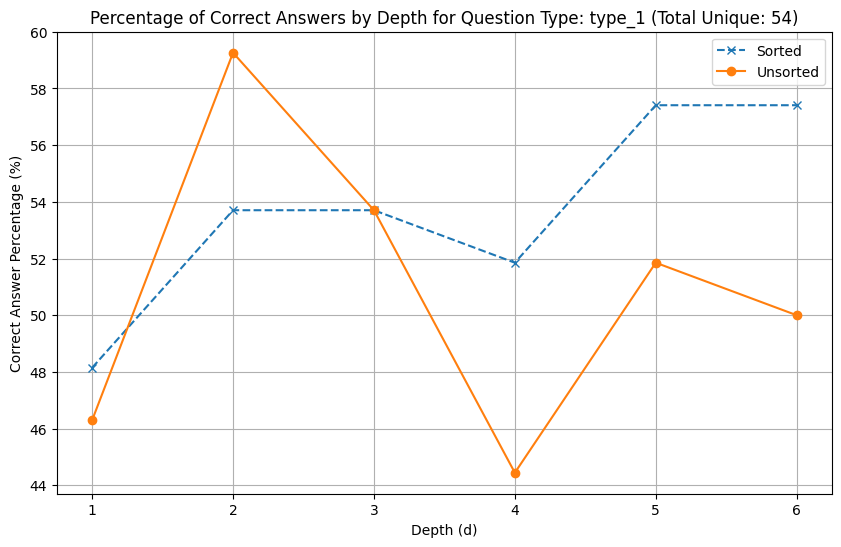

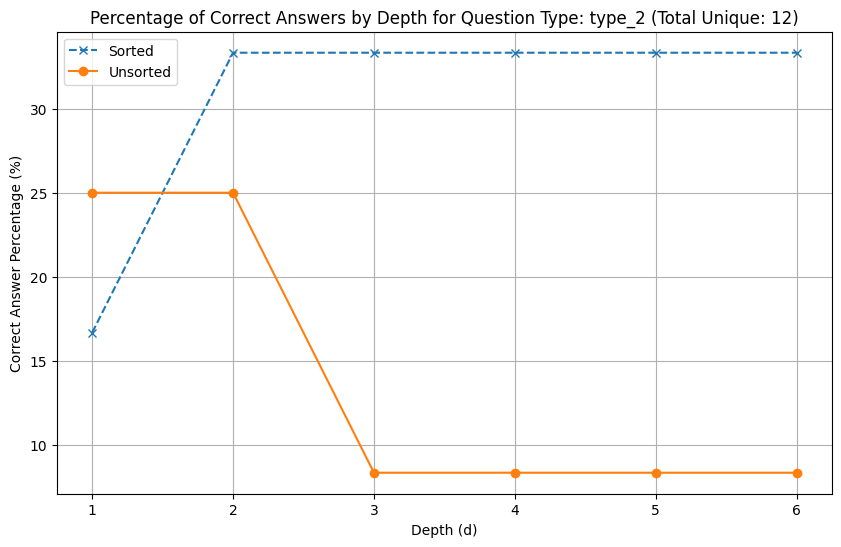

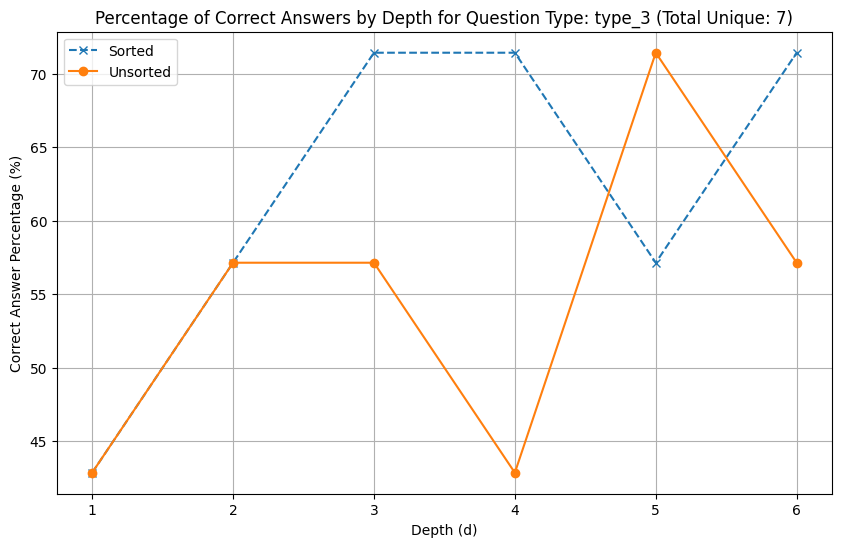

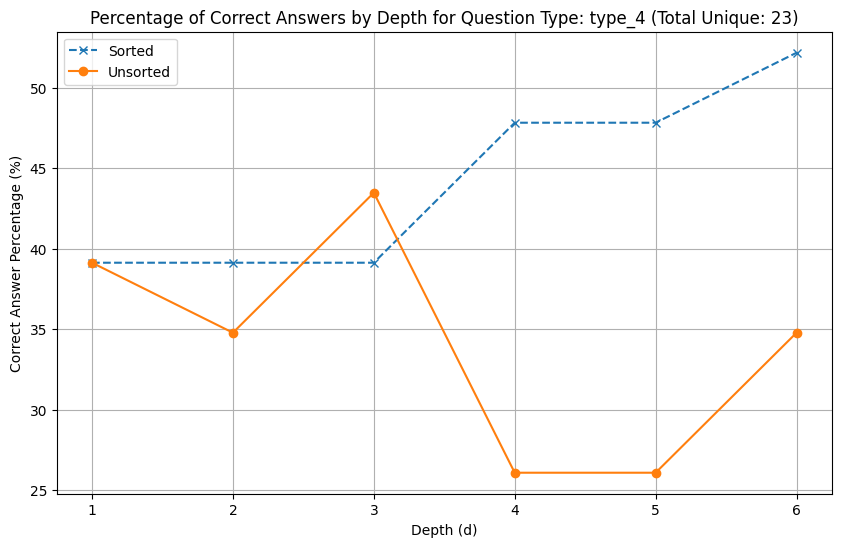

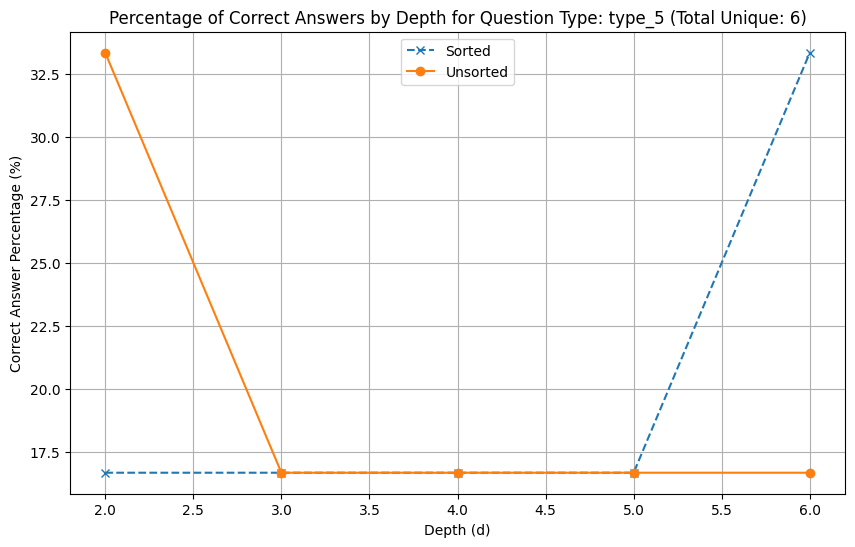

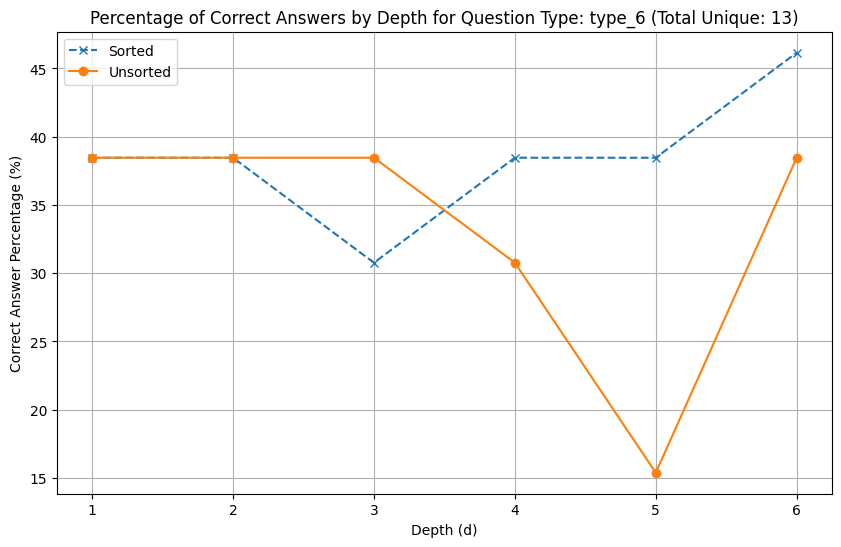

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re

# Load all CSV files following the specified naming pattern
file_pattern = "gpt_evaluations/evaluated_answers_sorted_unsorted_k*_d*.csv"
file_paths = glob.glob(file_pattern)

# Regex pattern to extract `k` and `d` values from filenames
pattern = r"evaluated_answers_sorted_unsorted_k(\d+)_d(\d+).csv"

# Initialize an empty DataFrame to hold combined data
all_data = pd.DataFrame()

# Loop through files, merge with sp_cot_data, and store combined data without duplicating questions
for file_path in file_paths:
    match = re.search(pattern, file_path)
    if match:
        k = int(match.group(1))
        d = int(match.group(2))
        
        # Load the CSV file and add k, d as columns
        df = pd.read_csv(file_path)
        df["k"] = k
        df["d"] = d
        
        # Merge with sp_cot_data on 'Question'
        merged_df = pd.merge(sp_cot_data, df, on='Question', suffixes=('_unsorted', '_sorted'))
        all_data = pd.concat([all_data, merged_df], ignore_index=True)

# Remove duplicate questions to avoid counting them multiple times across `k` values
all_data_unique_questions = all_data.drop_duplicates(subset=['Question'])

# Function to plot correct answer percentages by type as `d` increases
def plot_correct_answer_percentages_by_type(all_data, all_data_unique_questions):
    question_types = all_data_unique_questions['Type'].unique()

    # Loop over each question type
    for q_type in question_types:
        plt.figure(figsize=(10, 6))

        # Filter data for current question type
        type_data = all_data[all_data['Type'] == q_type]
        unique_type_data = all_data_unique_questions[all_data_unique_questions['Type'] == q_type]
        
        # Total number of unique questions of this type
        total_questions = len(unique_type_data)

        # Calculate percentages of correct answers for each depth `d`, grouped by sorted and unsorted
        sorted_correct_percentage = (
            type_data[type_data['Evaluation_sorted'] == 'correct'].groupby('d').size() / total_questions * 100
        )
        unsorted_correct_percentage = (
            type_data[type_data['Evaluation_unsorted'] == 'correct'].groupby('d').size() / total_questions * 100
        )

        # Only plot if there are values
        if not sorted_correct_percentage.empty and not unsorted_correct_percentage.empty:
            # Plot sorted and unsorted correct percentages
            plt.plot(sorted_correct_percentage.index, sorted_correct_percentage.values, label="Sorted", marker="x", linestyle="--")
            plt.plot(unsorted_correct_percentage.index, unsorted_correct_percentage.values, label="Unsorted", marker="o", linestyle="-")

            # Customize the plot
            plt.title(f"Percentage of Correct Answers by Depth for Question Type: {q_type} (Total Unique: {total_questions})")
            plt.xlabel("Depth (d)")
            plt.ylabel("Correct Answer Percentage (%)")
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
            print(f"No data available for question type: {q_type}")

# Generate plots
plot_correct_answer_percentages_by_type(all_data, all_data_unique_questions)
